#### Imports 

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from PIL import Image

from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### Importing Data

In [11]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))]) 
    tr_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return tr_df

In [12]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])
    ts_df = pd.DataFrame({"Class Path": class_paths, "Class": classes})
    return ts_df

In [13]:
tr_df = train_df(r"Data\Training")
ts_df = test_df(r"Data\Testing")

In [14]:
tr_df

,Class Path,Class
0,Data\Training\glioma\Tr-glTr_0000.jpg,glioma
1,Data\Training\glioma\Tr-glTr_0001.jpg,glioma
2,Data\Training\glioma\Tr-glTr_0002.jpg,glioma
3,Data\Training\glioma\Tr-glTr_0003.jpg,glioma
4,Data\Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,Data\Training\pituitary\Tr-pi_1452.jpg,pituitary
5708,Data\Training\pituitary\Tr-pi_1453.jpg,pituitary
5709,Data\Training\pituitary\Tr-pi_1454.jpg,pituitary
5710,Data\Training\pituitary\Tr-pi_1455.jpg,pituitary


In [15]:
ts_df

,Class Path,Class
0,Data\Testing\glioma\Te-glTr_0000.jpg,glioma
1,Data\Testing\glioma\Te-glTr_0001.jpg,glioma
2,Data\Testing\glioma\Te-glTr_0002.jpg,glioma
3,Data\Testing\glioma\Te-glTr_0003.jpg,glioma
4,Data\Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,Data\Testing\pituitary\Te-pi_0295.jpg,pituitary
1307,Data\Testing\pituitary\Te-pi_0296.jpg,pituitary
1308,Data\Testing\pituitary\Te-pi_0297.jpg,pituitary
1309,Data\Testing\pituitary\Te-pi_0298.jpg,pituitary


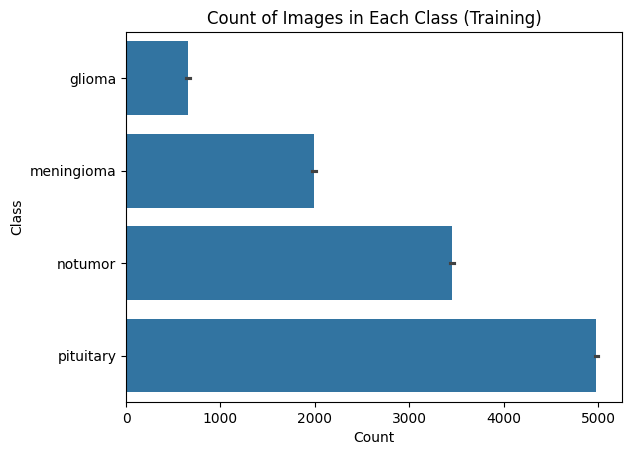

In [16]:
# Count of images in training dataset
plt.figure()
sns.barplot(tr_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Training)")
plt.show()

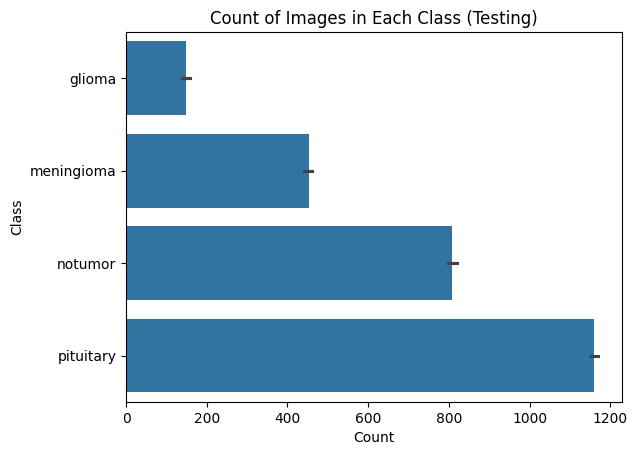

In [17]:
# Count of images in the training daaset
plt.figure()
sns.barplot(ts_df["Class"])
plt.xlabel("Count")
plt.ylabel("Class")
plt.title("Count of Images in Each Class (Testing)")
plt.show()

In [35]:
batch_size = 32
img_size = (299,299)

_gen = ImageDataGenerator(rescale=1/255)

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col="Class Path", 
                                  y_col="Class",
                                  batch_size=batch_size, 
                                  target_size=img_size,)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col="Class Path",
                                    y_col="Class", 
                                    batch_size=16, 
                                    target_size=img_size, 
                                    shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


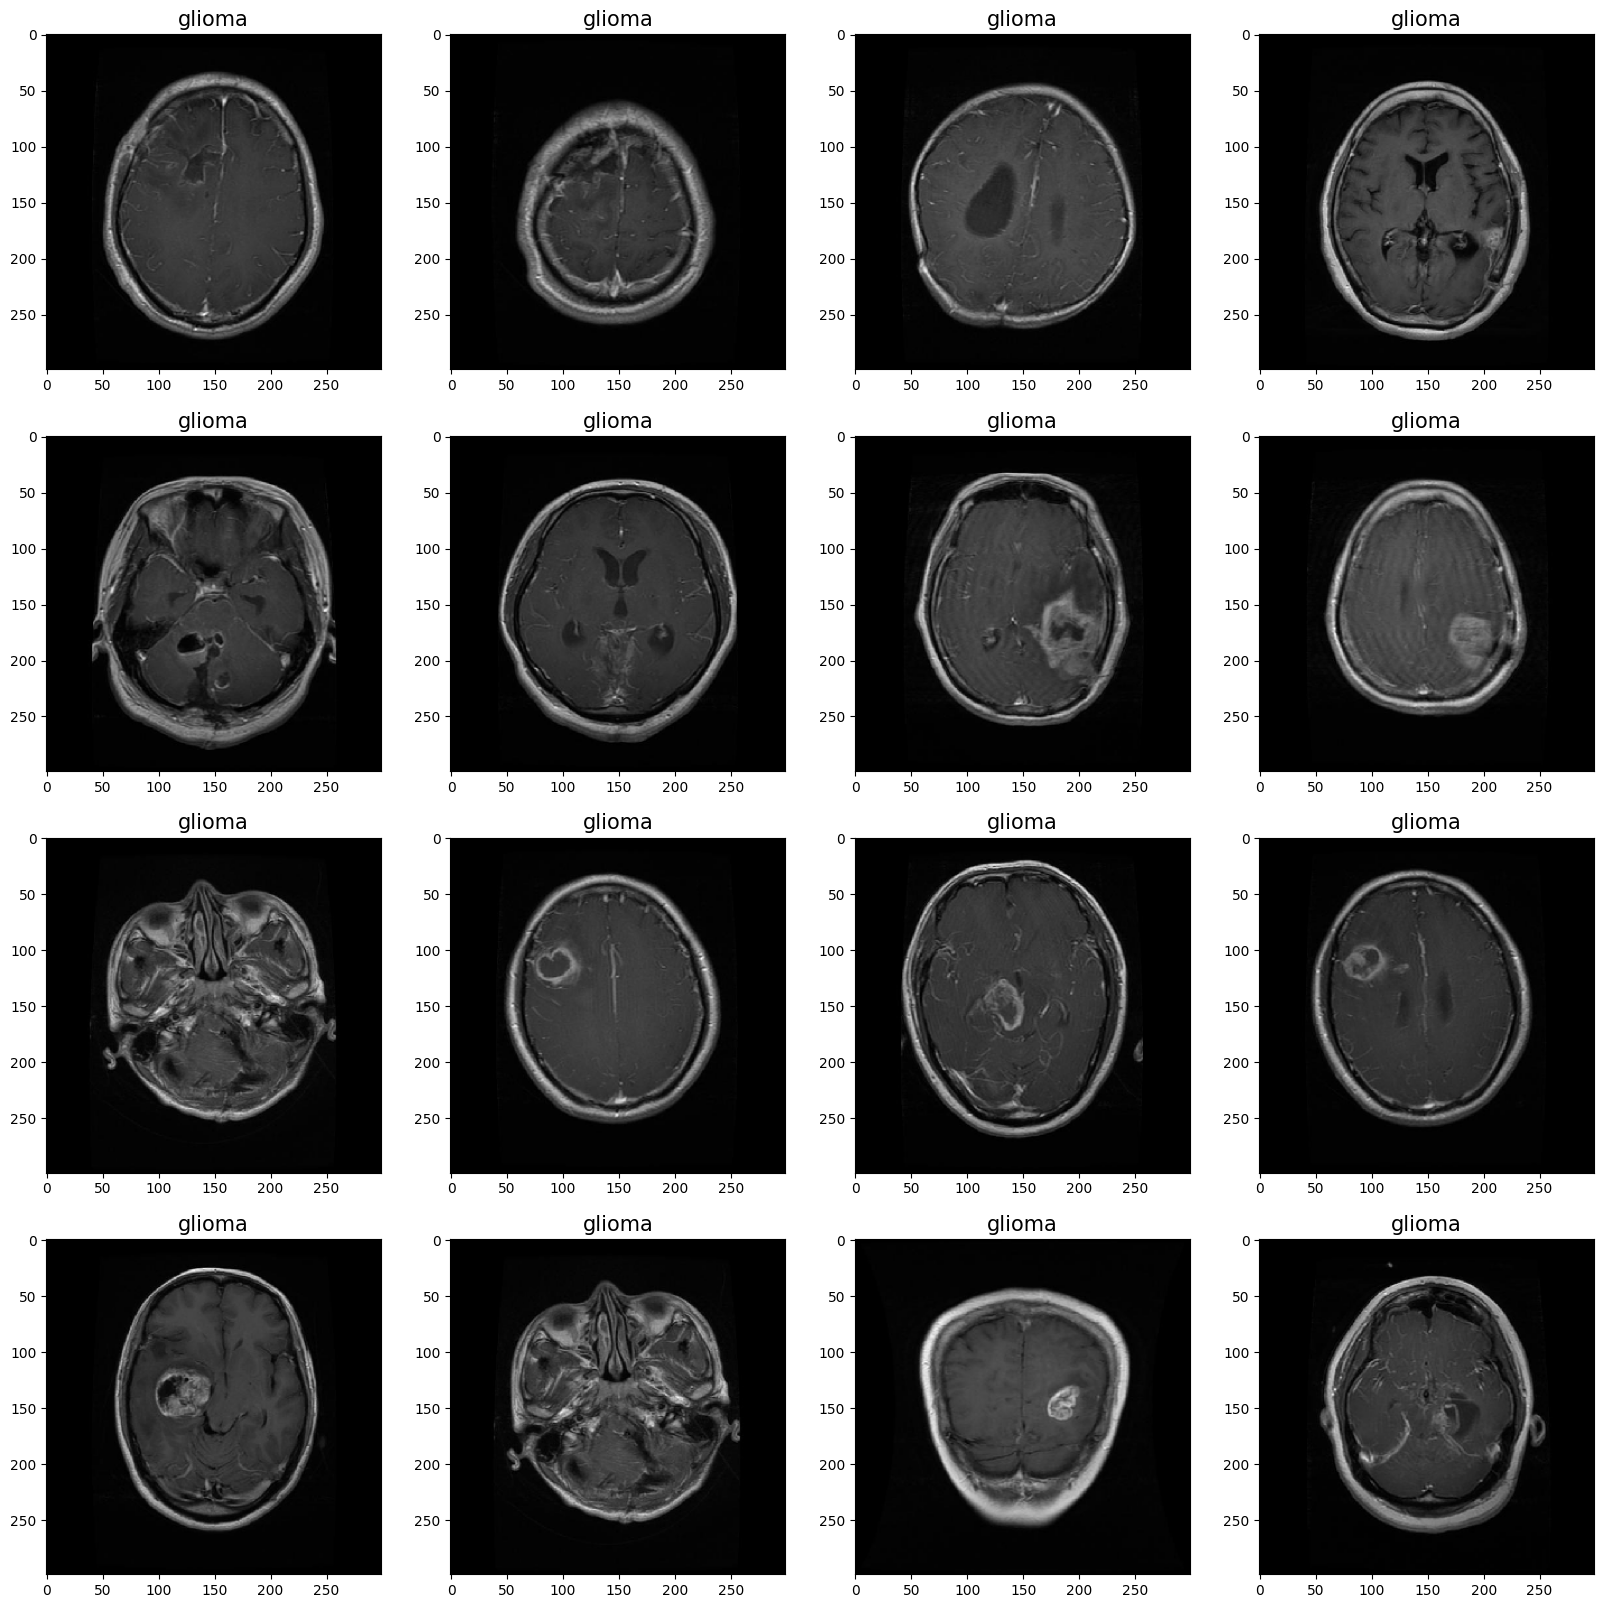

In [37]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20,20))
for i, (image,label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i+1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color="k", fontsize=15)
plt.show()

#### Inital CNN

In [55]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation="relu", input_shape=(299,299,3)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(4, activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(tr_gen, epochs=5, batch_size=64)
test_loss, test_acc = model.evaluate(ts_gen, verbose=2)
print("Loss:", test_loss)
print("Accuracy:", test_acc)

Epoch 1/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 128s 710ms/step - accuracy: 0.6542 - loss: 1.6224
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 242ms/step - accuracy: 0.8538 - loss: 0.4166
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 242ms/step - accuracy: 0.9233 - loss: 0.2242
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 43s 241ms/step - accuracy: 0.9617 - loss: 0.1275
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 257ms/step - accuracy: 0.9825 - loss: 0.0675


C:\Users\jalen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 - 31s - 377ms/step - accuracy: 0.9169 - loss: 0.2811
Loss: 0.2811413109302521
Accuracy: 0.9168573617935181


In [53]:
images, labels = next(ts_gen)
images[0].shape

(299, 299, 3)